# TPS 12/21 - Feature Engineering

In this notebook we test out some feature engineering techniques using XGBoost with default settings to see if we get any improvement over the baseline.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 6

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif

# Models
from sklearn.utils.extmath import softmax
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Save data as .feather format
original = pd.read_feather('../data/original.feather')
train = pd.read_feather('../data/train.feather')

In [4]:
# Drop un-useful
train.drop(["Soil_Type7", "Id", "Soil_Type15"], axis=1, inplace=True)
train = train[train.Cover_Type != 5]

In [5]:
# Split synthetic data
train, test = train_test_split(train, test_size = 1000000, random_state = RANDOM_SEED)
features = [x for x in train.columns if x not in ['Id','Cover_Type']]

gc.collect()

# Label Encoding
new_encoder = LabelEncoder()
train["Cover_Type"] = new_encoder.fit_transform(train["Cover_Type"])
test["Cover_Type"] = new_encoder.transform(test["Cover_Type"])

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
new_rows = list()
old_rows = list()

print(f'\nOriginal Train Size: {original.shape[0]} rows, {original.shape[1]} cols')
print(f'Synthetic Train Size: {train.shape[0]} rows, {train.shape[1]} cols')
print(f'Synthetic Test Size: {test.shape[0]} rows, {test.shape[1]} cols\n')


Original Train Size: 581012 rows, 55 cols
Synthetic Train Size: 2999999 rows, 53 cols
Synthetic Test Size: 1000000 rows, 53 cols



# Scoring Functions

In [6]:
# Scoring/Training Baseline Function
def score_newdata(processing = None):
    
    print('Data: TPS 12/21 (Synthetic)')
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0], len(train.Cover_Type.value_counts())))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = train[features].iloc[train_idx]
        X_valid = train[features].iloc[valid_idx]
        X_test = test[features]
        
        # Feature Engineering
        if processing:
            X_train = processing(X_train)
            X_valid = processing(X_valid)
            X_test = processing(X_test)
        
        # Training and Target Labels
        y_train = train['Cover_Type'].iloc[train_idx]
        y_valid = train['Cover_Type'].iloc[valid_idx]
        y_test = test['Cover_Type']
        
        gc.collect()
        
        # Create model
        model = XGBClassifier(
            booster = 'gbtree',
            tree_method = 'hist',
            eval_metric = 'mlogloss',
            random_state = RANDOM_SEED,
        )
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict_proba(X_test)
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy: {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    test_preds = np.argmax(test_preds, axis = 1)
    holdout_score = accuracy_score(y_test, test_preds)
    print("\nAverage CV Accuracy:", round(scores.mean(), 5))
    print("Worst CV Accuracy:", round(scores.min(), 5))
    print('\nHoldout Accuracy:', holdout_score)
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(y_test, test_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    return scores.mean(), holdout_score, oof_preds

In [7]:
# Scoring/Training Baseline Function
def score_olddata(processing = None):
    
    print('Data: Forest Covtype (Original)')
    
    # Store the holdout predictions
    oof_preds = np.zeros((original.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(original, original['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = original[features].iloc[train_idx]
        X_valid = original[features].iloc[valid_idx]
        
        # Feature Engineering
        if processing:
            X_train = processing(X_train)
            X_valid = processing(X_valid)
        
        # Training and Target Labels
        y_train = original['Cover_Type'].iloc[train_idx]
        y_valid = original['Cover_Type'].iloc[valid_idx]
        
        gc.collect()
        
        # Create model
        model = XGBClassifier(
            booster = 'gbtree',
            tree_method = 'hist',
            eval_metric = 'mlogloss',
            random_state = RANDOM_SEED,
        )
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy:  {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    print("\nAverage Accuracy:", round(scores.mean(), 5))
    print("Worst Accuracy:", round(scores.min(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(original['Cover_Type'], oof_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    return scores.mean(), oof_preds

# XGBoost Baseline

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95875 in 80.02s.
Fold 1 Accuracy: 0.95847 in 80.55s.
Fold 2 Accuracy: 0.95876 in 80.52s.
Fold 3 Accuracy: 0.95914 in 80.1s.
Fold 4 Accuracy: 0.95922 in 81.66s.
Fold 5 Accuracy: 0.95903 in 79.7s.

Average CV Accuracy: 0.95889
Worst CV Accuracy: 0.95847

Holdout Accuracy: 0.959299
Training Time: 482.54s



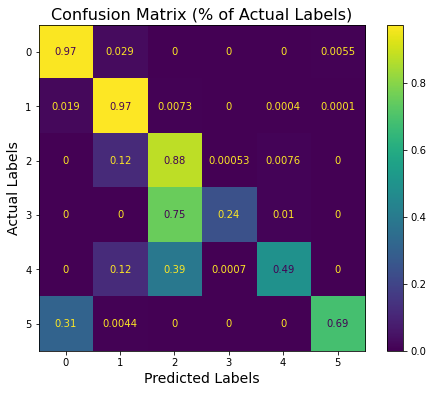

In [8]:
cv_score, test_score, oof_preds = score_newdata()

# Add rows
new_rows.append((
    'Baseline', cv_score, test_score, 
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87248 in 13.15s.
Fold 1 Accuracy:  0.87105 in 13.65s.
Fold 2 Accuracy:  0.86824 in 13.22s.
Fold 3 Accuracy:  0.8701 in 13.27s.
Fold 4 Accuracy:  0.86874 in 13.29s.
Fold 5 Accuracy:  0.86912 in 13.35s.

Average Accuracy: 0.86995
Worst Accuracy: 0.86824
Training Time: 79.93s



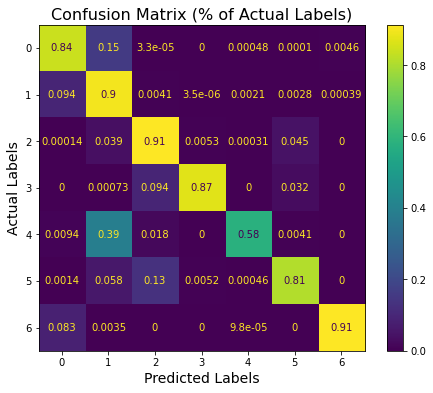

In [9]:
cv_score, oof_preds = score_olddata()

# Add rows
old_rows.append((
    'Baseline', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

# Feature Engineering

These function perform various feature cleaning and engineering tasks

## 1. Fix Aspect Range

In [10]:
# Fix aspect
def fix_aspect(data):
    
    df = data.copy()
    
    df["Aspect"][df["Aspect"] < 0] += 360
    df["Aspect"][df["Aspect"] > 359] -= 360
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95873 in 81.6s.
Fold 1 Accuracy: 0.95857 in 81.29s.
Fold 2 Accuracy: 0.95872 in 79.83s.
Fold 3 Accuracy: 0.95915 in 80.41s.
Fold 4 Accuracy: 0.95922 in 80.08s.
Fold 5 Accuracy: 0.95899 in 79.58s.

Average CV Accuracy: 0.9589
Worst CV Accuracy: 0.95857

Holdout Accuracy: 0.959286
Training Time: 482.79s



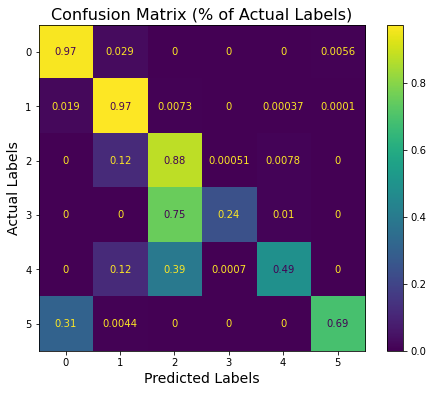

In [11]:
cv_score, test_score, oof_preds = score_newdata(fix_aspect)

new_rows.append((
    'Fix_Aspect', cv_score, test_score, 
    *recall_score(train['Cover_Type'], oof_preds, average = None)
))

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.8703 in 13.39s.
Fold 1 Accuracy:  0.87143 in 13.27s.
Fold 2 Accuracy:  0.8719 in 13.19s.
Fold 3 Accuracy:  0.87076 in 13.2s.
Fold 4 Accuracy:  0.87277 in 13.38s.
Fold 5 Accuracy:  0.87 in 13.16s.

Average Accuracy: 0.87119
Worst Accuracy: 0.87
Training Time: 79.6s



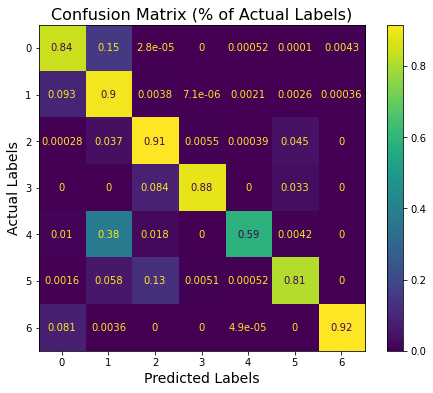

In [12]:
cv_score, oof_preds = score_olddata(fix_aspect)

# Add rows
old_rows.append((
    'Fix_Aspect', cv_score,
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

## 2. Fix Hillshade Range

In [13]:
# Fix Hillshade
def fix_hillshade(data):
    
    df = data.copy()
    
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95876 in 80.33s.
Fold 1 Accuracy: 0.95867 in 80.2s.
Fold 2 Accuracy: 0.9586 in 80.05s.
Fold 3 Accuracy: 0.95909 in 80.14s.
Fold 4 Accuracy: 0.9592 in 80.13s.
Fold 5 Accuracy: 0.95908 in 80.67s.

Average CV Accuracy: 0.9589
Worst CV Accuracy: 0.9586

Holdout Accuracy: 0.959231
Training Time: 481.52s



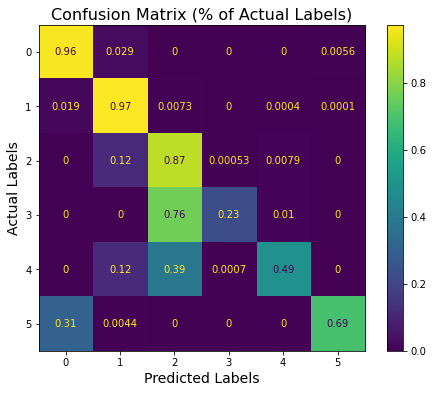

In [14]:
cv_score, test_score, oof_preds = score_newdata(fix_hillshade)

new_rows.append((
    'Fix_Hillshade', cv_score, test_score, 
    *recall_score(train['Cover_Type'], oof_preds, average = None)
))

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87248 in 13.13s.
Fold 1 Accuracy:  0.87105 in 13.27s.
Fold 2 Accuracy:  0.86824 in 13.3s.
Fold 3 Accuracy:  0.8701 in 13.27s.
Fold 4 Accuracy:  0.86874 in 13.27s.
Fold 5 Accuracy:  0.86912 in 13.52s.

Average Accuracy: 0.86995
Worst Accuracy: 0.86824
Training Time: 79.75s



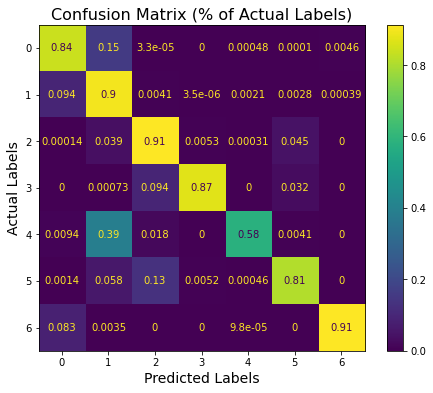

In [15]:
cv_score, oof_preds = score_olddata(fix_hillshade)

# Add rows
old_rows.append((
    'Fix_Hillshade', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

## 3. Water Distance Features

In [16]:
# Distance to Water
def water_distance_features(data):
    
    df = data.copy()
    
    # Taxicab Distance 
    df["Hydro_Taxicab"] = np.abs(df["Horizontal_Distance_To_Hydrology"]) + np.abs(df["Vertical_Distance_To_Hydrology"])

    # Euclidean distance to Hydrology
    df["Hydro_Euclid"] = (df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)**0.5
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95865 in 107.35s.
Fold 1 Accuracy: 0.95847 in 106.71s.
Fold 2 Accuracy: 0.95867 in 106.75s.
Fold 3 Accuracy: 0.95893 in 106.83s.
Fold 4 Accuracy: 0.95907 in 106.24s.
Fold 5 Accuracy: 0.95919 in 107.12s.

Average CV Accuracy: 0.95883
Worst CV Accuracy: 0.95847

Holdout Accuracy: 0.959186
Training Time: 640.99s



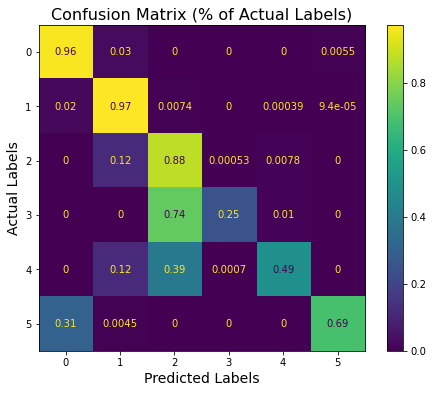

In [17]:
cv_score, test_score, oof_preds = score_newdata(water_distance_features)

new_rows.append((
    'Water_Dist', cv_score, test_score, 
    *recall_score(train['Cover_Type'], oof_preds, average = None)
))

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.86977 in 18.67s.
Fold 1 Accuracy:  0.87064 in 18.8s.
Fold 2 Accuracy:  0.87132 in 19.48s.
Fold 3 Accuracy:  0.87028 in 19.11s.
Fold 4 Accuracy:  0.86982 in 18.83s.
Fold 5 Accuracy:  0.87318 in 19.22s.

Average Accuracy: 0.87083
Worst Accuracy: 0.86977
Training Time: 114.12s



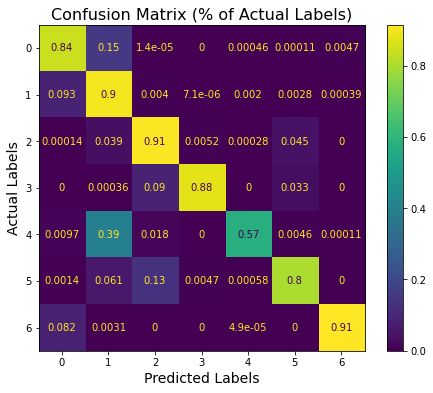

In [18]:
cv_score, oof_preds = score_olddata(water_distance_features)

# Add rows
old_rows.append((
    'Water_Dist', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

## 4. Count Features

In [19]:
# Create count features
def count_features(data):
    
    df = data.copy()
    soil_features = [x for x in df.columns if x.startswith("Soil_Type")]
    wilderness_features = [x for x in df.columns if x.startswith("Wilderness_Area")]

    # Count features
    df["Soil_Count"] = df[soil_features].apply(sum, axis=1)
    df["Wilderness_Count"] = df[wilderness_features].apply(sum, axis=1)
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.96068 in 86.42s.
Fold 1 Accuracy: 0.96048 in 85.94s.
Fold 2 Accuracy: 0.96072 in 86.72s.
Fold 3 Accuracy: 0.96085 in 88.8s.
Fold 4 Accuracy: 0.96087 in 90.12s.
Fold 5 Accuracy: 0.96089 in 91.11s.

Average CV Accuracy: 0.96075
Worst CV Accuracy: 0.96048

Holdout Accuracy: 0.961435
Training Time: 529.11s



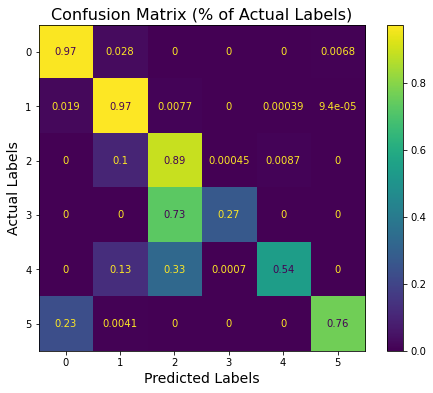

In [20]:
cv_score, test_score, oof_preds = score_newdata(count_features)

new_rows.append((
    'Count', cv_score, test_score, 
    *recall_score(train['Cover_Type'], oof_preds, average = None)
))

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87176 in 16.12s.
Fold 1 Accuracy:  0.86844 in 14.07s.
Fold 2 Accuracy:  0.86851 in 14.02s.
Fold 3 Accuracy:  0.86817 in 14.35s.
Fold 4 Accuracy:  0.86888 in 13.93s.
Fold 5 Accuracy:  0.87122 in 13.56s.

Average Accuracy: 0.8695
Worst Accuracy: 0.86817
Training Time: 86.05s



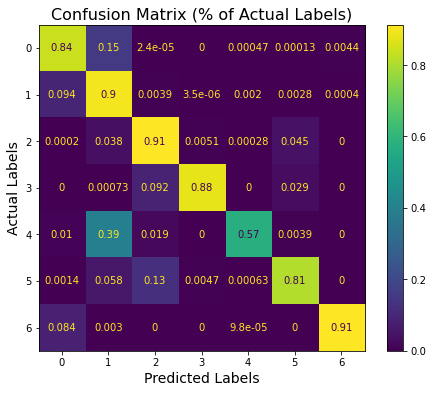

In [21]:
cv_score, oof_preds = score_olddata(count_features)

# Add rows
old_rows.append((
    'Count', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

## 5. Shade Features

In [22]:
# Create Shade features
def new_shade_features(data):
    
    df = data.copy()
    shade_features = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

    # Hillshade
    df["Hillshade_Avg"] = df[shade_features].mean(axis=1)
    df['Hillshade_Range'] = df[shade_features].max(axis=1) - df[shade_features].min(axis=1)
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95863 in 81.78s.
Fold 1 Accuracy: 0.95862 in 82.1s.
Fold 2 Accuracy: 0.95873 in 83.42s.
Fold 3 Accuracy: 0.95912 in 82.38s.
Fold 4 Accuracy: 0.95916 in 82.0s.
Fold 5 Accuracy: 0.95894 in 82.22s.

Average CV Accuracy: 0.95887
Worst CV Accuracy: 0.95862

Holdout Accuracy: 0.959283
Training Time: 493.89s



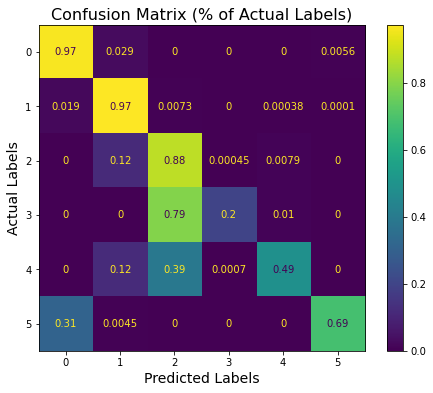

In [23]:
cv_score, test_score, oof_preds = score_newdata(new_shade_features)

new_rows.append((
    'Shade_Features', cv_score, test_score, 
    *recall_score(train['Cover_Type'], oof_preds, average = None)
))

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87 in 14.08s.
Fold 1 Accuracy:  0.87042 in 13.65s.
Fold 2 Accuracy:  0.87185 in 13.75s.
Fold 3 Accuracy:  0.87034 in 13.63s.
Fold 4 Accuracy:  0.87121 in 13.78s.
Fold 5 Accuracy:  0.87011 in 13.95s.

Average Accuracy: 0.87065
Worst Accuracy: 0.87
Training Time: 82.84s



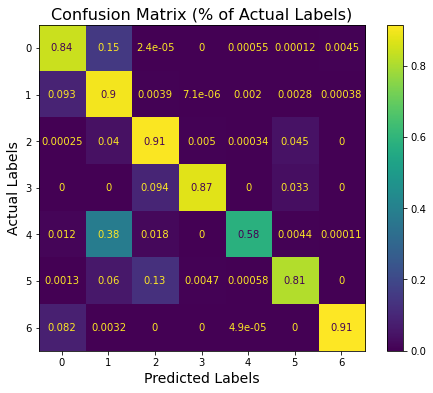

In [24]:
cv_score, oof_preds = score_olddata(new_shade_features)

# Add rows
old_rows.append((
    'Shade_Features', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

## 6. Distance Interaction Features

In [25]:
def distance_interactions(data):
    
    df = data.copy()
    df['Hydro_Fire_1'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])
    df['Hydro_Road_1'] = abs(df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])
    df['Hydro_Road_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_1'] = abs(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_2'] = abs(df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways'])
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95938 in 85.59s.
Fold 1 Accuracy: 0.95921 in 85.48s.
Fold 2 Accuracy: 0.95925 in 83.98s.
Fold 3 Accuracy: 0.9596 in 84.89s.
Fold 4 Accuracy: 0.9595 in 85.0s.
Fold 5 Accuracy: 0.95972 in 84.72s.

Average CV Accuracy: 0.95944
Worst CV Accuracy: 0.95921

Holdout Accuracy: 0.959903
Training Time: 509.65s



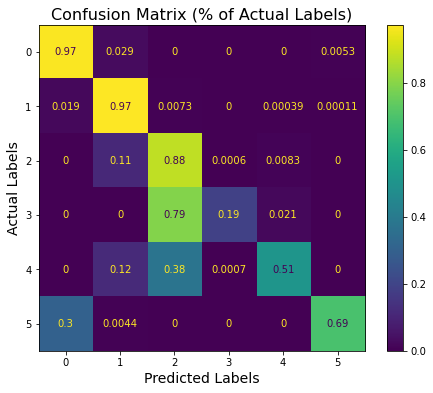

In [26]:
cv_score, test_score, oof_preds = score_newdata(distance_interactions)

new_rows.append((
    'Dist_Interactions', cv_score, test_score, 
    *recall_score(train['Cover_Type'], oof_preds, average = None)
))

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.89198 in 14.7s.
Fold 1 Accuracy:  0.89037 in 14.68s.
Fold 2 Accuracy:  0.89037 in 15.02s.
Fold 3 Accuracy:  0.88913 in 14.74s.
Fold 4 Accuracy:  0.89142 in 14.58s.
Fold 5 Accuracy:  0.88914 in 14.92s.

Average Accuracy: 0.8904
Worst Accuracy: 0.88913
Training Time: 88.63s



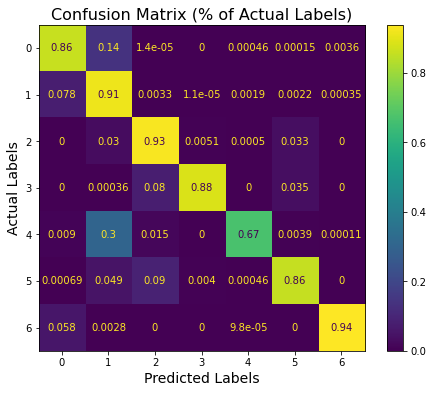

In [27]:
cv_score, oof_preds = score_olddata(distance_interactions)

# Add rows
old_rows.append((
    'Dist_Interactions', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

## 7. Misc. Interaction Features

In [28]:
def various_interactions(data):
    
    df = data.copy()
    df['EHiElv'] = df['Horizontal_Distance_To_Roadways'] * df['Elevation']
    df['EViElv'] = df['Vertical_Distance_To_Hydrology'] * df['Elevation']
    df['Highwater'] = (df.Vertical_Distance_To_Hydrology < 0).astype(int)
    df['EVDtH'] = df.Elevation - df.Vertical_Distance_To_Hydrology
    df['EHDtH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2
    df['Hillshade_3pm_is_zero'] = (df.Hillshade_3pm == 0).astype(int)
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95942 in 83.97s.
Fold 1 Accuracy: 0.95922 in 83.88s.
Fold 2 Accuracy: 0.95934 in 84.12s.
Fold 3 Accuracy: 0.95994 in 84.28s.
Fold 4 Accuracy: 0.95995 in 84.34s.
Fold 5 Accuracy: 0.95962 in 85.95s.

Average CV Accuracy: 0.95958
Worst CV Accuracy: 0.95922

Holdout Accuracy: 0.960048
Training Time: 506.53s



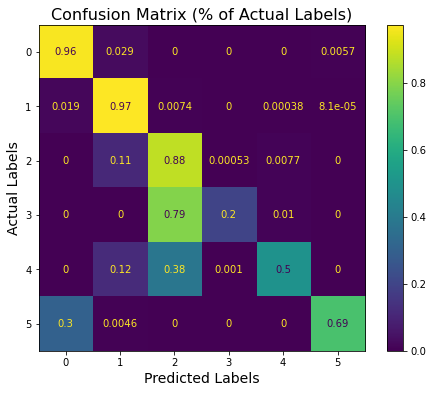

In [29]:
cv_score, test_score, oof_preds = score_newdata(various_interactions)

new_rows.append((
    'Various_Interactions', cv_score, test_score, 
    *recall_score(train['Cover_Type'], oof_preds, average = None)
))

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.88203 in 14.43s.
Fold 1 Accuracy:  0.87833 in 14.3s.
Fold 2 Accuracy:  0.87941 in 14.43s.
Fold 3 Accuracy:  0.88196 in 14.38s.
Fold 4 Accuracy:  0.88257 in 14.54s.
Fold 5 Accuracy:  0.88035 in 14.51s.

Average Accuracy: 0.88078
Worst Accuracy: 0.87833
Training Time: 86.58s



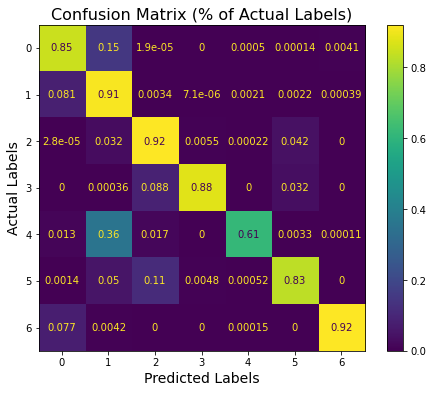

In [30]:
cv_score, oof_preds = score_olddata(various_interactions)

# Add rows
old_rows.append((
    'Various_Interactions', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

# Summary

In [31]:
pd.DataFrame.from_records(
    data = new_rows,
    columns = ['features','cv_scores','holdout','recall_0', 'recall_1','recall_2','recall_3','recall_4','recall_5']
).sort_values('holdout')

,features,cv_scores,holdout,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5
3,Water_Dist,0.958831,0.959186,0.963991,0.972241,0.879085,0.266904,0.495731,0.690229
2,Fix_Hillshade,0.958901,0.959231,0.964343,0.972301,0.877773,0.259786,0.490352,0.689415
5,Shade_Features,0.958867,0.959283,0.964308,0.972247,0.877841,0.238434,0.490937,0.689822
1,Fix_Aspect,0.958898,0.959286,0.964309,0.972282,0.878038,0.284698,0.489066,0.689950
0,Baseline,0.958894,0.959299,0.964401,0.972243,0.877875,0.270463,0.490352,0.689287
6,Dist_Interactions,0.959443,0.959903,0.964716,0.972516,0.880568,0.256228,0.516080,0.694102
7,Various_Interactions,0.959582,0.960048,0.964172,0.973062,0.881752,0.245552,0.500292,0.695236
4,Count,0.960748,0.961435,0.964493,0.972097,0.891254,0.291815,0.542159,0.759737


In [32]:
pd.DataFrame.from_records(
    data = old_rows,
    columns = ['features','cv_scores','recall_0', 'recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('cv_scores')

,features,cv_scores,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
4,Count,0.869497,0.840370,0.896538,0.910807,0.877685,0.574423,0.807105,0.913116
0,Baseline,0.869953,0.840852,0.897109,0.910360,0.872952,0.579374,0.806299,0.912969
2,Fix_Hillshade,0.869953,0.840852,0.897109,0.910360,0.872952,0.579374,0.806299,0.912969
5,Shade_Features,0.870655,0.841168,0.898077,0.910052,0.872224,0.580638,0.808199,0.914676
3,Water_Dist,0.870834,0.842258,0.898165,0.910444,0.876229,0.574002,0.801693,0.914627
1,Fix_Aspect,0.871192,0.842088,0.897837,0.911842,0.882781,0.587591,0.809063,0.915212
7,Various_Interactions,0.880777,0.846139,0.911045,0.920708,0.879505,0.611714,0.830253,0.918333
6,Dist_Interactions,0.890403,0.859970,0.914208,0.930945,0.883873,0.668598,0.855012,0.938762


# Note: Soil Types

We see the soil type count feature helps a lot with the synthetic data but not at all for the original data. The reason for this is that there are no overlapping soil types in the original data but there are in the synthetic data. Hence, soil type count has no variance in the original data.

# Soil Type Features

Next, were going to attempt to leverage domain knowledge to derive further categorical features using the soil types. From the description of the dataset, we have the following:
```
     ID    Code	    Description
     
	 1	   2702		Cathedral family - Rock outcrop complex, extremely stony.
	 2	   2703		Vanet - Ratake families complex, very stony.
	 3	   2704		Haploborolis - Rock outcrop complex, rubbly.
	 4	   2705		Ratake family - Rock outcrop complex, rubbly.
	 5	   2706		Vanet family - Rock outcrop complex complex, rubbly.
	 6	   2717		Vanet - Wetmore families - Rock outcrop complex, stony.
	 7	   3501		Gothic family.
	 8	   3502		Supervisor - Limber families complex.
	 9	   4201		Troutville family, very stony.
	10	   4703		Bullwark - Catamount families - Rock outcrop complex, rubbly.
	11	   4704		Bullwark - Catamount families - Rock land complex, rubbly.
	12	   4744		Legault family - Rock land complex, stony.
	13	   4758		Catamount family - Rock land - Bullwark family complex, rubbly.
	14	   5101		Pachic Argiborolis - Aquolis complex.
	15	   5151		unspecified in the USFS Soil and ELU Survey.
	16	   6101		Cryaquolis - Cryoborolis complex.
	17	   6102		Gateview family - Cryaquolis complex.
	18	   6731		Rogert family, very stony.
	19	   7101		Typic Cryaquolis - Borohemists complex.
	20	   7102		Typic Cryaquepts - Typic Cryaquolls complex.
	21	   7103		Typic Cryaquolls - Leighcan family, till substratum complex.
	22	   7201		Leighcan family, till substratum, extremely bouldery.
	23	   7202		Leighcan family, till substratum - Typic Cryaquolls complex.
	24	   7700		Leighcan family, extremely stony.
	25	   7701		Leighcan family, warm, extremely stony.
	26	   7702		Granile - Catamount families complex, very stony.
	27	   7709		Leighcan family, warm - Rock outcrop complex, extremely stony.
	28	   7710		Leighcan family - Rock outcrop complex, extremely stony.
	29	   7745		Como - Legault families complex, extremely stony.
	30	   7746		Como family - Rock land - Legault family complex, extremely stony.
	31	   7755		Leighcan - Catamount families complex, extremely stony.
	32	   7756		Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
	33	   7757		Leighcan - Catamount families - Rock outcrop complex, extremely stony.
	34	   7790		Cryorthents - Rock land complex, extremely stony.
	35	   8703		Cryumbrepts - Rock outcrop - Cryaquepts complex.
	36	   8707		Bross family - Rock land - Cryumbrepts complex, extremely stony.
	37	   8708		Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
	38	   8771		Leighcan - Moran families - Cryaquolls complex, extremely stony.
	39	   8772		Moran family - Cryorthents - Leighcan family complex, extremely stony.
	40	   8776		Moran family - Cryorthents - Rock land complex, extremely stony.
    
        Note:   First digit:  climatic zone             Second digit:  geologic zones
                1.  lower montane dry                   1.  alluvium
                2.  lower montane                       2.  glacial
                3.  montane dry                         3.  shale
                4.  montane                             4.  sandstone
                5.  montane dry and montane             5.  mixed sedimentary
                6.  montane and subalpine               6.  unspecified in the USFS ELU Survey
                7.  subalpine                           7.  igneous and metamorphic
                8.  alpine                              8.  volcanic

        The third and fourth ELU digits are unique to the mapping unit 
        and have no special meaning to the climatic or geologic zones.
```

In [33]:
# Dictionary for mapping to ELU Code
code = {
    1:2702,2:2703,3:2704,4:2705,5:2706,
    6:2717,7:3501,8:3502,9:4201,10:4703,
    11:4704,12:4744,13:4758,14:5101,15:5151,
    16:6101,17:6102,18:6731,19:7101,20:7102,
    21:7103,22:7201,23:7202,24:7700,25:7701,
    26:7702,27:7709,28:7710,29:7745,30:7746,
    31:7755,32:7756,33:7757,34:7790,35:8703,
    36:8707,37:8708,38:8771,39:8772,40:8776
}

# Ordinal Vs One Hot Encoding

In [34]:
# Fix aspect
def consolidate_soil_types(input_df):
    data = input_df.copy()
    soil_features = sorted([x for x in data.columns if x.startswith("Soil_Type")])
    soil_type = list()
    for index, row in data[soil_features].iterrows():
        found = False
        for i, val in enumerate(row, start = 1):
            if val != 0:
                soil_type.append(i)
                found = True
                break
        if not found: soil_type.append(None)
    data['Soil_Type'] = soil_type
    nonsoil_features = [x for x in data.columns if x not in soil_features]
    return data[nonsoil_features]

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87766 in 12.26s.
Fold 1 Accuracy:  0.87602 in 12.13s.
Fold 2 Accuracy:  0.87513 in 12.03s.
Fold 3 Accuracy:  0.87641 in 11.93s.
Fold 4 Accuracy:  0.87702 in 12.11s.
Fold 5 Accuracy:  0.87798 in 11.99s.

Average Accuracy: 0.8767
Worst Accuracy: 0.87513
Training Time: 72.45s



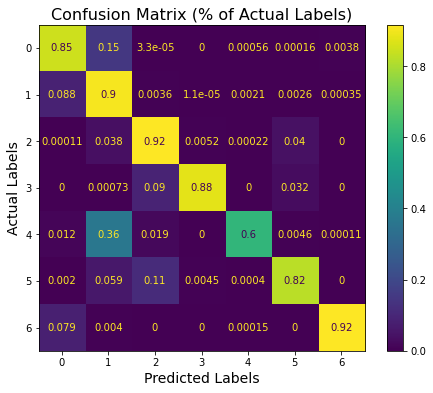

In [35]:
cv_score, oof_preds = score_olddata(consolidate_soil_types)

# Add rows
old_rows.append((
    'Ordinal Encoding', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

In [39]:
original = consolidate_soil_types(original)
features = [x for x in original.columns if x not in ['Id','Cover_Type']]

## 1. Climatic Zone

Since each observation may contain many soil types and therefore many 

1.  lower montane dry                   
2.  lower montane                       
3.  montane dry                         
4.  montane                             
5.  montane dry and montane             
6.  montane and subalpine               
7.  subalpine                           
8.  alpine                              

In [40]:
def climatic_zone_original(input_df):
    data = input_df.copy()
    data['Climatic Zone'] = data['Soil_Type'].apply(lambda x: int(str(code[x])[0]))
    return data

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87783 in 8.94s.
Fold 1 Accuracy:  0.87727 in 9.17s.
Fold 2 Accuracy:  0.87367 in 9.26s.
Fold 3 Accuracy:  0.87719 in 9.44s.
Fold 4 Accuracy:  0.87631 in 9.29s.
Fold 5 Accuracy:  0.87576 in 9.29s.

Average Accuracy: 0.87634
Worst Accuracy: 0.87367
Training Time: 55.39s



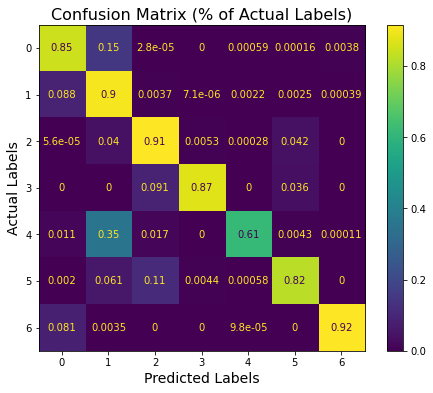

In [41]:
cv_score, oof_preds = score_olddata(climatic_zone_original)

# Add rows
old_rows.append((
    'Climatic Zone', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

## 2. Geologic Zone (Nominal)

1.  alluvium
2.  glacial
3.  shale
4.  sandstone
5.  mixed sedimentary
6.  unspecified in the USFS ELU Survey
7.  igneous and metamorphic
8.  volcanic

In [42]:
def geologic_zone_original(input_df):
    data = input_df.copy()
    data['Geologic_Zone'] = data['Soil_Type'].apply(lambda x: int(str(code[x])[1]))
    return data

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87724 in 9.28s.
Fold 1 Accuracy:  0.87521 in 9.24s.
Fold 2 Accuracy:  0.87494 in 9.27s.
Fold 3 Accuracy:  0.87478 in 9.18s.
Fold 4 Accuracy:  0.87491 in 9.27s.
Fold 5 Accuracy:  0.87828 in 9.27s.

Average Accuracy: 0.87589
Worst Accuracy: 0.87478
Training Time: 55.51s



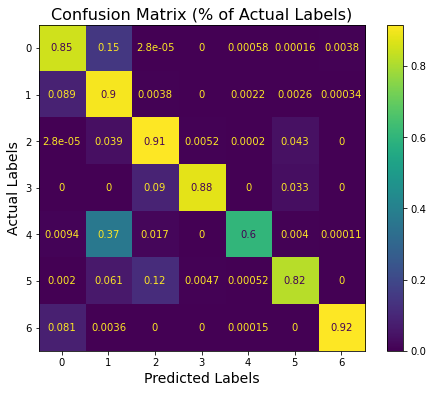

In [43]:
cv_score, oof_preds = score_olddata(geologic_zone_original)

# Add rows
old_rows.append((
    'Geologic_Zone', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

## 3. Surface Cover by Stones/Boulders (Ordinal)

According to the [USDA reference](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/ref/?cid=nrcs142p2_054253#surface_fragments) on soil profiling:

1. **(Stony/Bouldery)** — Stones or boulders cover 0.01 to less than 0.1 percent of the surface. The smallest stones are at least 8 meters apart; the smallest boulders are at least 20 meters apart (fig. 3-9).

2. **(Very Stony/Very Bouldery)** — Stones or boulders cover 0.1 to less than 3 percent of the surface. The smallest stones are not less than 1 meter apart; the smallest boulders are not less than 3 meters apart (fig. 3-10).

3. **(Extremely Stony/Extremely Bouldery)** — Stones or boulders cover 3 to less than 15 percent of the surface. The smallest stones are as little as 0.5 meter apart; the smallest boulders are as little as 1 meter apart (fig. 3-11).

4. **(Rubbly)** — Stones or boulders cover 15 to less than 50 percent of the surface. The smallest stones are as little as 0.3 meter apart; the smallest boulders are as little as 0.5 meter apart. In most places it is possible to step from stone to stone or jump from boulder to boulder without touching the soil (fig. 3-12).

5. **(Very Rubbly)** — Stones or boulders appear to be nearly continuous and cover 50 percent or more of the surface. The smallest stones are less than 0.03 meter apart; the smallest boulders are less than 0.05 meter apart. Classifiable soil is among the rock fragments, and plant growth is possible (fig. 3-13).

In [44]:
# Group IDs
no_desc = [7,8,14,15,16,17,19,20,21,23,35]
stony = [6,12]
very_stony = [2,9,18,26]
extremely_stony = [1,22,24,25,27,28,29,30,31,32,33,34,36,37,38,39,40]
rubbly = [3,4,5,10,11,13]

# Create dictionary
surface_cover = {i:None for i in no_desc}
surface_cover.update({i:0 for i in stony})
surface_cover.update({i:1 for i in very_stony})
surface_cover.update({i:2 for i in extremely_stony})
surface_cover.update({i:3 for i in rubbly})

In [45]:
def surface_cover_original(input_df):
    data = input_df.copy()
    data['Surface_Cover'] = data['Soil_Type'].apply(lambda x: surface_cover[x])
    return data

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87361 in 12.36s.
Fold 1 Accuracy:  0.87545 in 12.37s.
Fold 2 Accuracy:  0.87352 in 12.34s.
Fold 3 Accuracy:  0.8772 in 12.49s.
Fold 4 Accuracy:  0.87675 in 12.44s.
Fold 5 Accuracy:  0.87508 in 12.38s.

Average Accuracy: 0.87527
Worst Accuracy: 0.87352
Training Time: 74.4s



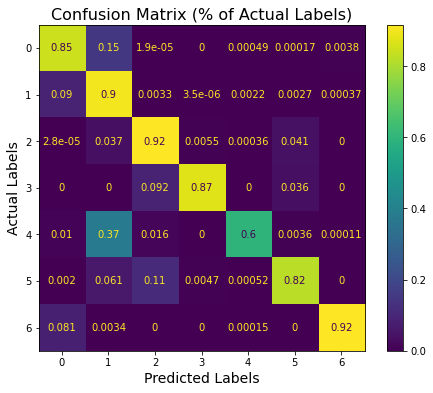

In [46]:
cv_score, oof_preds = score_olddata(surface_cover_original)

# Add rows
old_rows.append((
    'Surface Cover', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

## 4. Rock Size (Ordinal)

According to the [USDA reference](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/ref/?cid=nrcs142p2_054253#fragments) on soil profile:

* Stones/Stony - 250–600 mm diameter
* Boulders/Bouldery - > 600 mm diameter

We can use these to perhaps derive useful features

In [47]:
no_desc = [7,8,14,15,16,17,19,20,21,23,35]
stones = [1,2,6,9,12,18,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40]
boulders = [22]
rubble = [3,4,5,10,11,13]

rock_size = {i:None for i in no_desc}
rock_size.update({i:0 for i in stones})
rock_size.update({i:1 for i in boulders})
rock_size.update({i:2 for i in rubble})

In [48]:
def rock_size_original(input_df):
    data = input_df.copy()
    data['Rock_Size'] = data['Soil_Type'].apply(lambda x: rock_size[x])
    return data

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87377 in 12.31s.
Fold 1 Accuracy:  0.87613 in 12.35s.
Fold 2 Accuracy:  0.87404 in 13.14s.
Fold 3 Accuracy:  0.87729 in 12.47s.
Fold 4 Accuracy:  0.87452 in 12.42s.
Fold 5 Accuracy:  0.87697 in 13.03s.

Average Accuracy: 0.87545
Worst Accuracy: 0.87377
Training Time: 75.73s



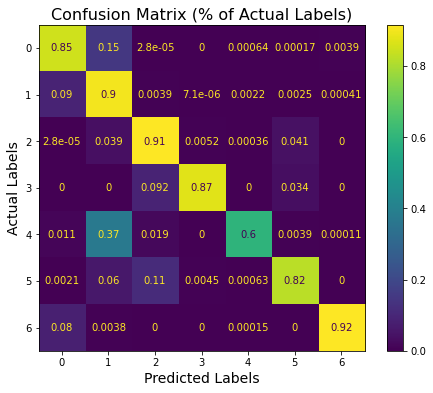

In [49]:
cv_score, oof_preds = score_olddata(rock_size_original)

# Add rows
old_rows.append((
    'Rock_Size', cv_score, 
    *recall_score(original['Cover_Type'], oof_preds, average = None)
))

# Summary (so far)

In [50]:
pd.DataFrame.from_records(
    data = old_rows,
    columns = ['features','cv_scores','recall_0', 'recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('cv_scores')

,features,cv_scores,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
4,Count,0.869497,0.840370,0.896538,0.910807,0.877685,0.574423,0.807105,0.913116
0,Baseline,0.869953,0.840852,0.897109,0.910360,0.872952,0.579374,0.806299,0.912969
2,Fix_Hillshade,0.869953,0.840852,0.897109,0.910360,0.872952,0.579374,0.806299,0.912969
5,Shade_Features,0.870655,0.841168,0.898077,0.910052,0.872224,0.580638,0.808199,0.914676
3,Water_Dist,0.870834,0.842258,0.898165,0.910444,0.876229,0.574002,0.801693,0.914627
1,Fix_Aspect,0.871192,0.842088,0.897837,0.911842,0.882781,0.587591,0.809063,0.915212
11,Surface Cover,0.875268,0.846700,0.901119,0.916121,0.871860,0.597177,0.822710,0.915700
12,Rock_Size,0.875452,0.847961,0.900932,0.914415,0.873680,0.595386,0.820752,0.915700
10,Geologic_Zone,0.875892,0.848504,0.901705,0.912429,0.877685,0.602128,0.816088,0.915651
9,Climatic Zone,0.876338,0.846445,0.903477,0.912821,0.872224,0.614347,0.820464,0.915748


# Final Features: Family (Nominal)

Group soil features on whether or not they belong to certain descriptions. Will one-hot encode most likely, perhaps use dimension reduction to decrease sparsity.

In [ ]:
cathedral = []
rock_outcroup = []
rock_land = []
vanet = []
ratake = []
wetmore = []
haploborolis = []
gothic = []
supervisor = []
limber = []
troutville = []
bullwark = []
legault = []
pachic_argiborolis = []
aquolis = []
cryoborolis = []
Cryaquolis = []
Cryaquepts = []
Cryaquolls = []
Cryorthents = []
Cryumbrepts = []
gateview = []
rogert = []
till_substratum = []
granile = []
Catamount = []
Leighcan = []
como = []
catamount = []
Bross = []
Moran = []